# LSTM Temperature Forecasting
Examples of LSTM forecasting of min daily temperatures. 
Based om this tutorial:
* <a href="https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/">How to Develop LSTM Models for Time Series Forecasting</a>

## Imports

In [1]:
import pandas as pd
import numpy as np
import time
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from numpy.random import seed
from numpy.random import randn
from numpy import array
from math import sin, fabs, sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM, ConvLSTM2D, Flatten
import matplotlib.pyplot as plt
%matplotlib inline

## Load Dataset

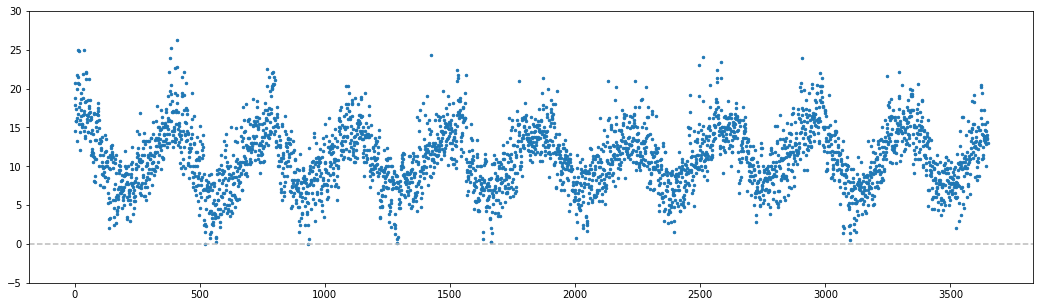

In [2]:
# Load min temperatures dataset
data = pd.read_csv("../data/daily-min-temperatures.csv").values
x = np.array(data[:,-1]).astype("float")
y = range(0,len(x))

# Plot
plt.figure(figsize=(18,5))
plt.ylim(-5,30)
plt.axhline(y=0, color="#bbbbbb", linestyle="dashed")
plt.scatter(y,x,s=6)
plt.show()

# Settings
n_steps = 8 # 16
n_features = 1
xt = x[n_steps:]
yt = y[n_steps:]

## Useful functions

In [3]:
# Calculate prediction error
def calc_error(xhat):
    mse = 0
    mae = 0
    for v,vhat in zip(xt, xhat):
        mae += fabs(v-vhat)
        mse += (v-vhat)**2
    mae /= len(xt)
    mse /= len(xt)

    print("Result: mae={0:.3f}, mse={1:.3f}, rmse={2:.3f}".format(mae, mse, sqrt(mse)))

# Calculate prediction error for a subset of the data
def calc_test_error(xhat, start, no):
    mse = 0
    mae = 0
    for v,vhat in zip(xt[start:start+no], xhat):
        mae += fabs(v-vhat)
        mse += (v-vhat)**2
    mae /= len(xt)
    mse /= len(xt)

    print("Result: mae={0:.3f}, mse={1:.3f}, rmse={2:.3f}".format(mae, mse, sqrt(mse)))
    
# Plot result
def plot_result(xhat):
    plt.figure(figsize=(18,5))
    plt.ylim(-5,30)
    plt.axhline(y=0, color="#bbbbbb", linestyle="dashed")
    plt.plot(yt, xhat, c="red")
    plt.scatter(yt, xt, c="blue", s=6)
    plt.show()

# Pliot result for a subset of the data
def plot_test_result(xhat, start, no):
    plt.figure(figsize=(18,5))
    plt.ylim(-5,30)
    plt.axhline(y=0, color="#bbbbbb", linestyle="dashed")
    plt.plot(yt[start:start+no], xhat, c="red")
    plt.scatter(yt[start:start+no], x[tlim:tlim+no_f], c="blue", s=6)
    plt.show()

# Train and evaluate model
def train_and_evaluate(model, X, epochs=200):
    # Start timer
    start = time.time()

    # Fit (train) model
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Make predictions
    xhat = model.predict(X).flatten()
    
    # Stop timer
    end = time.time()
    
    # Show results
    print("Time elapsed: {0:0.2f} sec".format(end - start))
    calc_error(xhat)
    plot_result(xhat)

## Data Preparation

In [4]:
# Split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # Find the end of this pattern
        end_ix = i + n_steps
        # Check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # Gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# Split into samples
Xs, y = split_sequence(x, n_steps)

## Vanilla LSTM

Time elapsed: 72.33 sec
Result: mae=1.464, mse=3.647, rmse=1.910


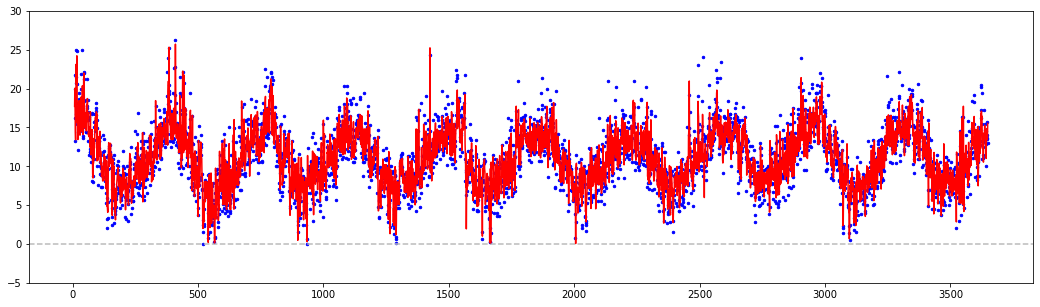

In [5]:
# Define model
model = Sequential()
model.add(LSTM(64, activation="relu", input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

# Reshape from [samples, timesteps] into [samples, timesteps, features]
X = Xs.reshape((Xs.shape[0], Xs.shape[1], 1))

# Train and evaluate model
train_and_evaluate(model, X, epochs=200)

## Stacked LSTM

Time elapsed: 142.79 sec
Result: mae=1.048, mse=1.970, rmse=1.404


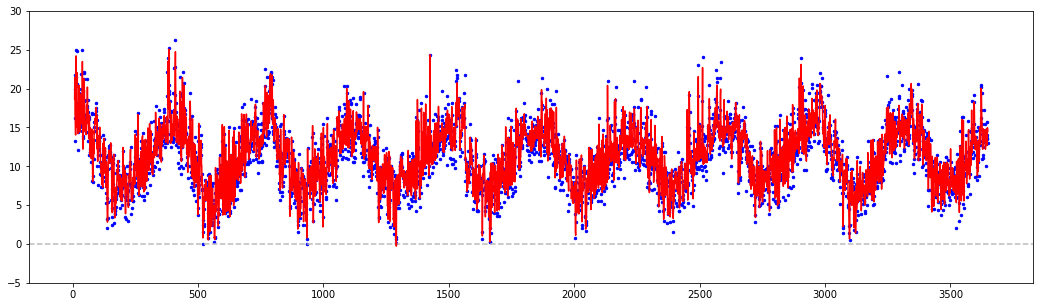

In [6]:
# Define model
model = Sequential()
model.add(LSTM(64, activation="relu", return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(64, activation="relu"))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

# Reshape from [samples, timesteps] into [samples, timesteps, features]
X = Xs.reshape((Xs.shape[0], Xs.shape[1], n_features))

# Train and evaluate model
train_and_evaluate(model, X, epochs=200)

## ConvLSTM

Time elapsed: 109.10 sec
Result: mae=1.407, mse=3.366, rmse=1.835


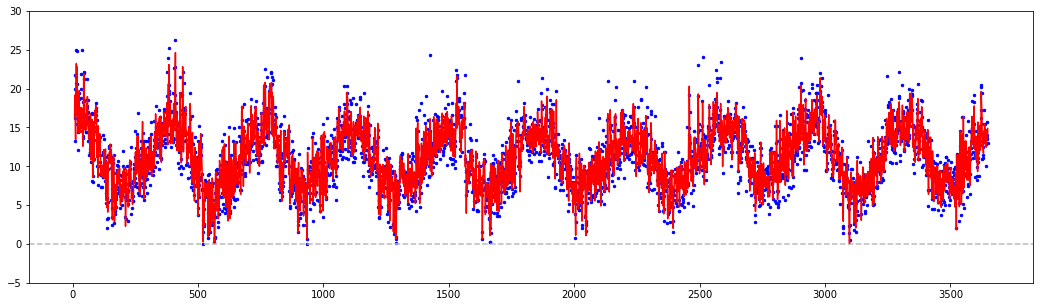

In [7]:
# Settings
n_seq = 4
n_step = 2

# Define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation="relu", input_shape=(n_seq, 1, n_step, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

# Reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
X = Xs.reshape((Xs.shape[0], n_seq, 1, n_step, n_features))

# Train and evaluate model
train_and_evaluate(model, X, epochs=200)

## LSTM Forecasting
Evaluates how well forecasting (evaluating on a test set) works.

Time elapsed: 28.41 sec
Result: mae=0.224, mse=0.806, rmse=0.898


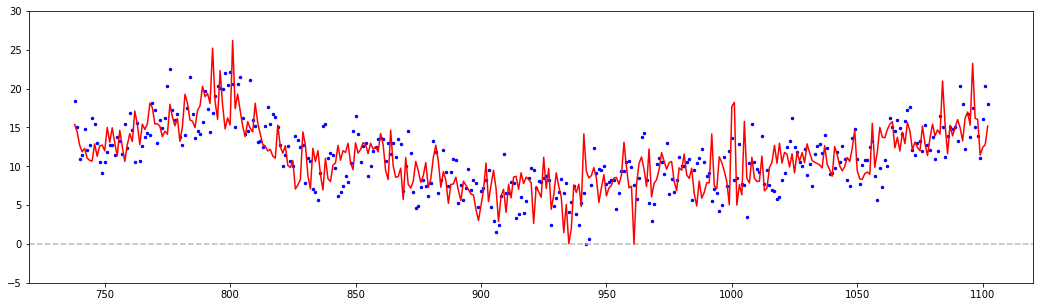

In [8]:
# Split data into sequences
Xs, y = split_sequence(x, n_steps)

# Reshape from [samples, timesteps] into [samples, timesteps, features]
X = Xs.reshape((Xs.shape[0], Xs.shape[1], 1))

# Train on two years data
tlim = 365 * 2

# Cut out training part
X_train = X[:tlim]
y_train = y[:tlim]

# Number of forecasts
no_f = 365
X_test = X[tlim:tlim+no_f]
y_test = y[tlim:tlim+no_f]

# Start timer
start = time.time()
    
# Define Stacked LSTM model
model = Sequential()
model.add(LSTM(64, activation="relu", return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(64, activation="relu"))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

# Fit model
model.fit(X_train, y_train, epochs=200, verbose=0)

# Make predictions
xhat = xhat = model.predict(X_test).flatten()

# Stop timer
end = time.time()

# Show results
print("Time elapsed: {0:0.2f} sec".format(end - start))
calc_test_error(xhat, tlim, no_f)

# Plot
plot_test_result(xhat, tlim, no_f)

## XGBoost
Based on this tutorial:
* <a href="https://machinelearningmastery.com/xgboost-for-time-series-forecasting/">How to Use XGBoost for Time Series Forecasting</a>

Time elapsed: 0.07 sec
Result: mae=1.405, mse=3.325, rmse=1.823


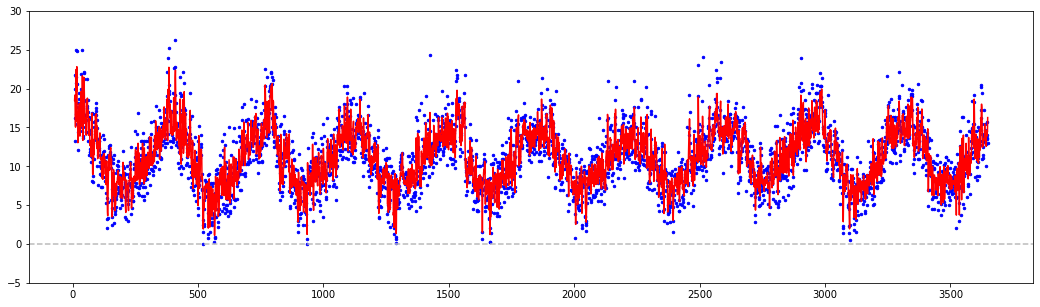

In [9]:
# Start timer
start = time.time()

# Build and train model
model = XGBRegressor(objective='reg:squarederror', n_estimators=20)
model.fit(Xs, y)

# Make predictions
xhat = model.predict(Xs)

# Stop timer
end = time.time()

# Show results
print("Time elapsed: {0:0.2f} sec".format(end - start))
calc_error(xhat)

# Plot
plot_result(xhat)

## XGBoost Forecasting

Time elapsed: 0.01 sec
Result: mae=0.220, mse=0.789, rmse=0.888


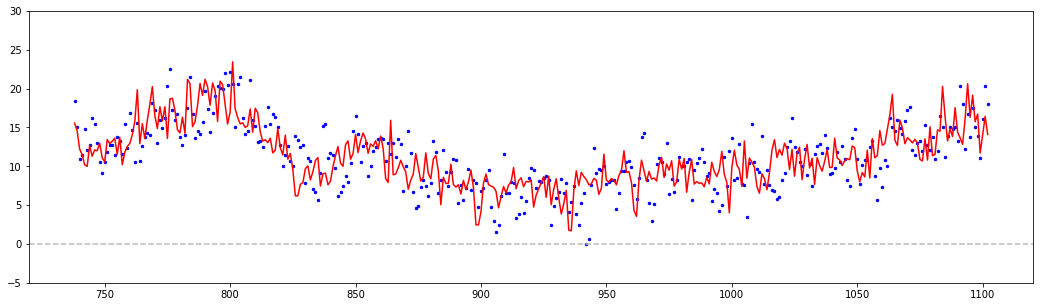

In [10]:
# Train on two years data
tlim = 365 * 2

# Cut out training part
X_train = Xs[:tlim]
y_train = y[:tlim]

# Number of forecasts
no_f = 365
X_test = Xs[tlim:tlim+no_f]
y_test = y[tlim:tlim+no_f]

# Start timer
start = time.time()

# Build and train model
model = XGBRegressor(objective='reg:squarederror', n_estimators=20)
model.fit(X_train, y_train)

# Make predictions
xhat = model.predict(X_test)

# Stop timer
end = time.time()

# Show results
print("Time elapsed: {0:0.2f} sec".format(end - start))
calc_test_error(xhat, tlim, no_f)

# Plot
plot_test_result(xhat, tlim, no_f)

## KNN Forecasting

Time elapsed: 0.01 sec
Result: mae=0.212, mse=0.721, rmse=0.849


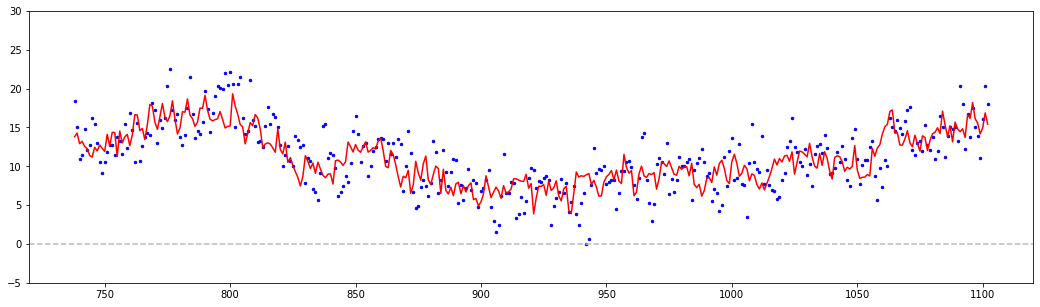

In [11]:
# Train on two years data
tlim = 365 * 2

# Cut out training part
X_train = Xs[:tlim]
y_train = y[:tlim]

# Number of forecasts
no_f = 365
X_test = Xs[tlim:tlim+no_f]
y_test = y[tlim:tlim+no_f]

# Start timer
start = time.time()

# Build and train model
model = KNeighborsRegressor(n_neighbors=10)
model.fit(X_train, y_train)

# Make predictions
xhat = model.predict(X_test)

# Stop timer
end = time.time()

# Show results
print("Time elapsed: {0:0.2f} sec".format(end - start))
calc_test_error(xhat, tlim, no_f)

# Plot
plot_test_result(xhat, tlim, no_f)